# **Spatial-Spectral Summarizer Fusion Network (S³F-Net) Baseline Implementation**

This notebook contains the full implementation of **Spatial CNN-based Baseline** on the Breast Ultrasound Images (BUSI) dataset, for comparisons with **S³F-Net**. Edit the file paths according to your setup.

## **Data Preparation**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP, IMPORTS AND DATA LOADING (FOR BUSI)
# ==============================================================================
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Configuration ---
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 200
RANDOM_STATE = 42

# --- Paths ---
DATASET_PATH = "/content/drive/MyDrive/Medical Image Segmentation/Breast Ultrasound Images/Breast Ultrasound Images/Dataset_BUSI_with_GT"
SAVE_FOLDER = "/content/drive/MyDrive/S3F_Net_Models"
os.makedirs(SAVE_FOLDER, exist_ok=True)
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "Spatial_only_Baseline_BUSI.keras")

In [ ]:
# ==============================================================================
# BLOCK 2: DATA LOADING AND PREPROCESSING FOR BUSI
# ==============================================================================
def load_busi_dataset(dataset_path):
    """Loads images and labels from the BUSI dataset structure."""
    categories = ['benign', 'malignant', 'normal']
    images, labels = [], []
    print(f"Loading BUSI dataset from: {dataset_path}")
    for class_idx, category in enumerate(categories):
        category_path = os.path.join(dataset_path, category)
        if not os.path.exists(category_path) or not os.path.isdir(category_path): continue
        for filename in os.listdir(category_path):
            if '_mask' in filename or not filename.lower().endswith('.png'): continue
            img_path = os.path.join(category_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                img = img.astype('float32') / 255.0
                images.append(img[..., np.newaxis])
                labels.append(class_idx)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
    if not images: raise ValueError("No images loaded.")
    return np.array(images), np.array(labels), categories

try:
    images, labels, CLASS_NAMES = load_busi_dataset(DATASET_PATH)
    print(f"Dataset loaded successfully: {len(images)} images.")
    indices = np.arange(len(images))
    train_indices, test_indices = train_test_split(indices, test_size=0.2, stratify=labels, random_state=RANDOM_STATE)
    X_train, X_test = images[train_indices], images[test_indices]
    y_train, y_test = labels[train_indices], labels[test_indices]
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"\nClass names: {CLASS_NAMES}")
    print(f"Data split: {len(X_train)} training, {len(X_test)} testing samples.")
    X_val, y_val = X_test, y_test

except Exception as e:
    print(f"An error occurred during data loading: {e}"); exit()

Loading BUSI dataset from: /content/drive/MyDrive/Medical Image Segmentation/Breast Ultrasound Images/Breast Ultrasound Images/Dataset_BUSI_with_GT
Dataset loaded successfully: 780 images.

Class names: ['benign', 'malignant', 'normal']
Data split: 624 training, 156 testing samples.


## **Spatial CNN Baseline Model Building**

In [ ]:
# ==============================================================================
# BLOCK 3: MODEL ARCHITECTURE (SPATIAL-ONLY Baseline FOR BUSI)
# ==============================================================================
# This block defines the Spatial-Only baseline model, designed for a direct
# comparison with the S³F-Net architectures.

# --- Encoder Definition (Identical to the S³F-Net's spatial branch) ---
def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

# --- Spatial-Only CNN Model Builder ---
def build_spatial_only_classifier(input_shape, num_classes):
    """Builds the classifier using only the spatial encoder and its head."""
    inputs = layers.Input(input_shape)

    # 1. Building Encoder
    features = build_spatial_encoder(inputs)

    # 2. Converting feature map to vector
    x = layers.GlobalAveragePooling2D()(features)

    # 3. Classifier Head (Matching the "Spatial Tower Head" from the S³F-Net)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # 4. Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="Spatial_Only_Classifier")

    # Compiling with the same optimizer and CE loss
    model.compile(optimizer=optimizers.Adam(0.0003),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("Spatial-Only model architecture is ready for BUSI.")

Spatial-Only model architecture definition is ready.


In [ ]:
# ==============================================================================
# BLOCK 4: CUSTOM CALLBACK AND TRAINING (SPATIAL-ONLY BASELINE)
# ==============================================================================
from sklearn.metrics import f1_score

# --- Custom F1 Score Callback to use 'weighted' average ---
class F1ScoreCallback(callbacks.Callback):
    def __init__(self, validation_data, filepath, patience=25):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.filepath = filepath
        self.patience = patience
        self.best_f1 = -1.0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_proba = self.model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calculating the 'weighted' F1-score
        weighted_f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        logs['val_f1_weighted'] = weighted_f1

        print(f" - val_f1_weighted: {weighted_f1:.4f}", end="")

        if weighted_f1 > self.best_f1:
            print(f" (New best F1, saving model to {self.filepath})")
            self.best_f1 = weighted_f1
            self.model.save(self.filepath)
            self.wait = 0
        else:
            print()
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered based on weighted F1-score.")
                self.model.stop_training = True

# --- Defining the model path for this baseline experiment ---
CLASSIFIER_MODEL_PATH_BASELINE = os.path.join(SAVE_FOLDER, "Spatial_only_Baseline_BUSI.keras")

# --- Building the Model ---
print("\n--- Building Spatial-Only Classifier ---")
classifier_model_baseline = build_spatial_only_classifier(X_train.shape[1:], num_classes=len(CLASS_NAMES))
classifier_model_baseline.summary()

# --- Define Callbacks ---
f1_callback_baseline = F1ScoreCallback(validation_data=(X_val, y_val),
                                       filepath=CLASSIFIER_MODEL_PATH_BASELINE,
                                       patience=60)

reduce_lr_baseline = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=40,
                                                 min_lr=1e-6,
                                                 verbose=1)

# --- Training the Model ---
print("\n--- Training Spatial-Only Baseline (Monitoring Weighted F1-Score) ---")
history_baseline = classifier_model_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[f1_callback_baseline, reduce_lr_baseline]
)

print("\n--- Training Finished ---")


--- Building Spatial-Only Classifier ---


Model: "Spatial_Only_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 32, 32, 256)    │             

 Total params: 1,308,771 (4.99 MB)

 Trainable params: 1,306,787 (4.98 MB)

 Non-trainable params: 1,984 (7.75 KB)


--- Training Spatial-Only Baseline (Monitoring Weighted F1-Score) ---
Epoch 1/200
37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3780 - loss: 1.6139 - val_f1_weighted: 0.1142 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/spatial_only_weighted_f1.keras)
39/39 ━━━━━━━━━━━━━━━━━━━━ 30s 323ms/step - accuracy: 0.3776 - loss: 1.6068 - val_accuracy: 0.2692 - val_loss: 1.1506 - val_f1_weighted: 0.1142 - learning_rate: 3.0000e-04
Epoch 2/200
37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3836 - loss: 1.3793 - val_f1_weighted: 0.1142
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3838 - loss: 1.3788 - val_accuracy: 0.2692 - val_loss: 1.2951 - val_f1_weighted: 0.1142 - learning_rate: 3.0000e-04
Epoch 3/200
37/39 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4153 - loss: 1.2667 - val_f1_weighted: 0.1142
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.4178 - loss: 1.2643 - val_accuracy: 0.2692 - val_loss: 1.3945 - val_f1_weighted: 0.1142 - learnin



--- Final Evaluation of Spatial-Only Baseline on Unseen Test Set ---
Loading best model from: /content/drive/MyDrive/S2F_Net_Models/spatial_only_weighted_f1.keras

--- Calculating Loss and Accuracy on Test Set ---
Test Loss:      0.5040
Test Accuracy:  0.8462
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 253ms/step

--- Detailed Performance Metrics ---
Macro F1 Score:   0.8205
Weighted F1 Score:0.8479
Cohen's Kappa:    0.7426
MCC:              0.7437
AUC-ROC (Macro):  0.9568
AUC-ROC (Weighted):0.9547

--- Classification Report ---
              precision    recall  f1-score   support

      benign     0.9146    0.8621    0.8876        87
   malignant     0.8182    0.8571    0.8372        42
      normal     0.7000    0.7778    0.7368        27

    accuracy                         0.8462       156
   macro avg     0.8109    0.8323    0.8205       156
weighted avg     0.8515    0.8462    0.8479       156



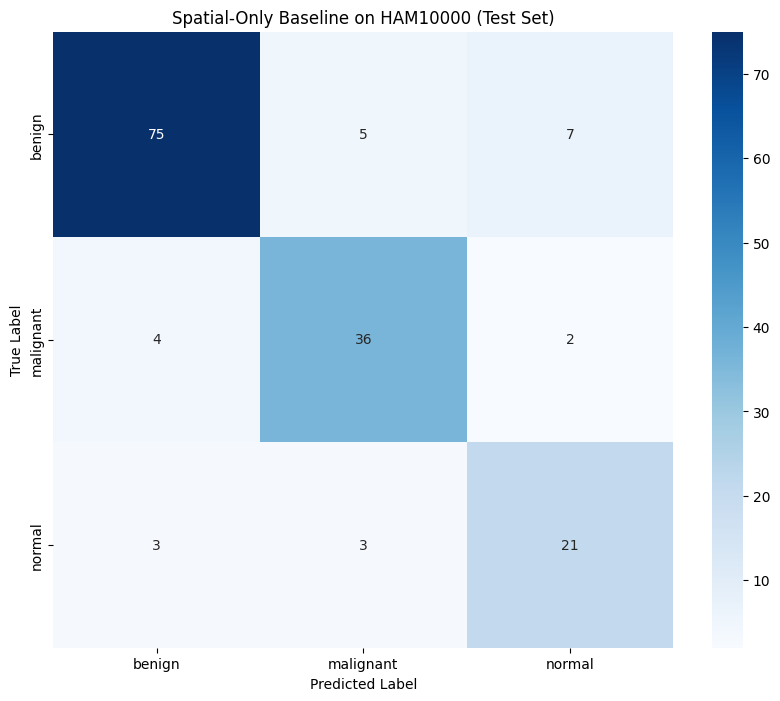


--- Training History Plots ---


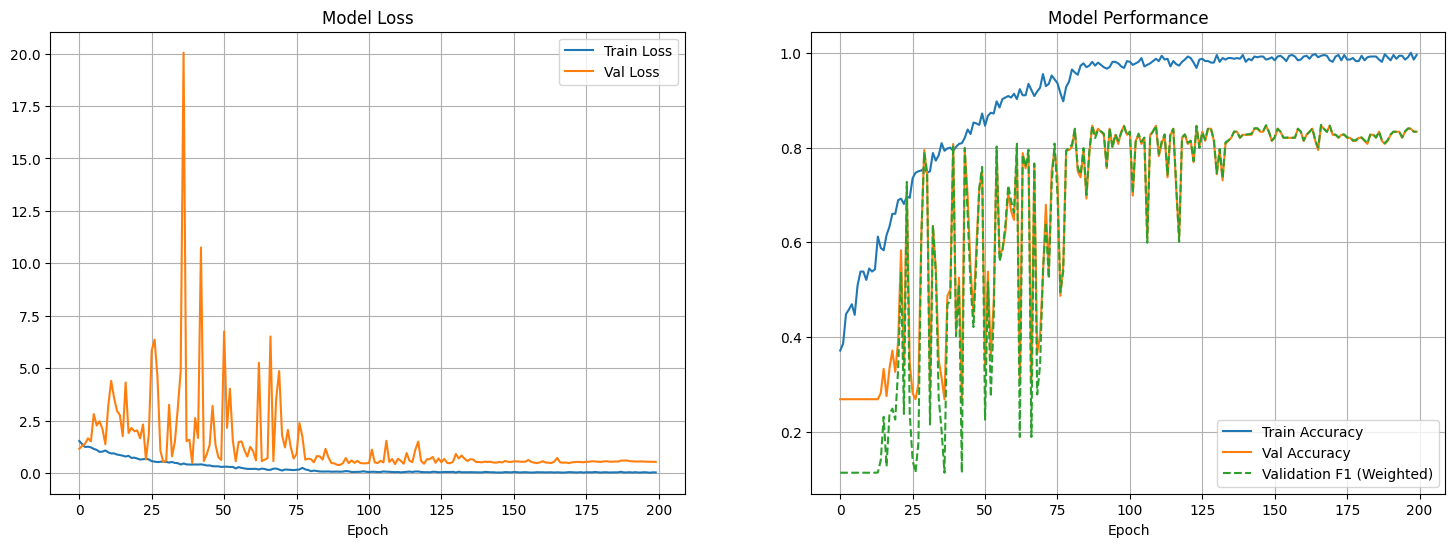


--- ROC Curve Analysis ---


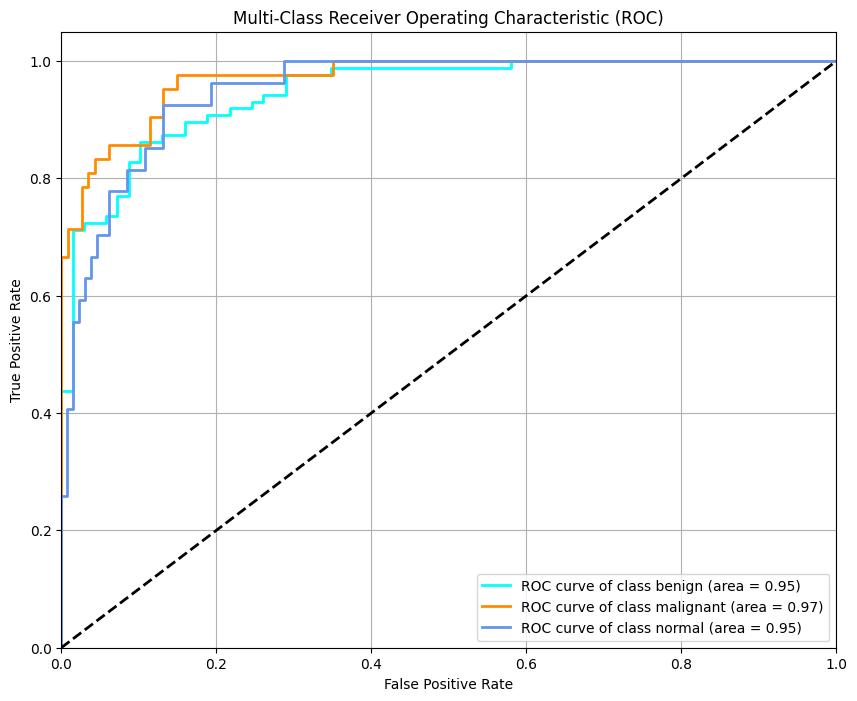


--- Script Finished ---


In [ ]:
# ======================
# BLOCK 5: EVALUATION
# ======================
print("\n\n--- Final Evaluation on BUSI dataset ---")

try:
    print(f"Loading best model from: {CLASSIFIER_MODEL_PATH_BASELINE}")
    best_model = models.load_model(CLASSIFIER_MODEL_PATH_BASELINE)

    # --- 1. Evaluating Loss and Accuracy ---
    print("\n--- Calculating Loss and Accuracy on Test Set ---")
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss:      {loss:.4f}")
    print(f"Test Accuracy:  {accuracy:.4f}")

    # --- 2. Getting Predictions ---
    y_pred_proba = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # --- 3. Detailed Metrics ---
    print("\n--- Detailed Performance Metrics ---")
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    print(f"Macro F1 Score:   {macro_f1:.4f}")
    print(f"Weighted F1 Score:{weighted_f1:.4f}")

    kappa = cohen_kappa_score(y_test, y_pred_classes)
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    print(f"Cohen's Kappa:    {kappa:.4f}")
    print(f"MCC:              {mcc:.4f}")

    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    weighted_auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Macro):  {auc_roc:.4f}")
    print(f"AUC-ROC (Weighted):{weighted_auc_roc:.4f}")

    # --- 4. Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, digits=4, zero_division=0))

    # --- 5. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.title('Spatial-Only Baseline on BUSI')       # It was set to HAM10000 by mistake while running the script
    plt.show()

    # --- 6. Plotting Training History ---
    if 'history_baseline' in locals() or 'history_baseline' in globals():
        print("\n--- Training History Plots ---")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        ax1.plot(history_baseline.history['loss'], label='Train Loss')
        ax1.plot(history_baseline.history['val_loss'], label='Val Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)
        ax2.plot(history_baseline.history['accuracy'], label='Train Accuracy')
        ax2.plot(history_baseline.history['val_accuracy'], label='Val Accuracy')
        if 'val_f1_weighted' in history_baseline.history:
            ax2.plot(history_baseline.history['val_f1_weighted'], label='Validation F1 (Weighted)', linestyle='--')
        ax2.set_title('Model Performance')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)
        plt.show()

    # --- 7. ROC Curve Plot ---
    print("\n--- ROC Curve Analysis ---")
    y_test_binarized = label_binarize(y_test, classes=range(len(CLASS_NAMES)))
    n_classes = y_test_binarized.shape[1]
    fpr, tpr, roc_auc_dict = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {CLASS_NAMES[i]} (area = {roc_auc_dict[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during evaluation: {e}")

print("\n--- Script Finished ---")